# Chapter 8.8 Computing

In [86]:
sessionInfo()

R version 3.4.4 (2018-03-15)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] party_1.3-1         strucchange_1.5-1   sandwich_2.5-0     
 [4] zoo_1.8-3           modeltools_0.2-22   mvtnorm_1.0-8      
 [7] xtable_1.8-3        caret_6.0-81        ggplot2_3.1.0      
[10] lattice_0.20-35     randomForest_4.6-14 mlbench_2.1-1      

loaded via a namespace (and not attached):
 [1] jsonlite_1.5       splines_3.4.4      foreach_1.4.4      prodlim_2018.04.18
 [5] assertthat_0.2.0   coin_1.2-2         ipred_0.9-8        pillar_1.3.0      
 [9] glue_1.3.

## 8.1 Recreate the simulated data from Exercise 7.2:

In [87]:
library(mlbench)
set.seed(200)
simulated <- mlbench.friedman1(200, sd = 1)
simulated <- cbind(simulated$x, simulated$y)
simulated <- as.data.frame(simulated)
colnames(simulated)[ncol(simulated)] <- "y"

### (a) Fit a random forest model to all of the predictors, then estimate the variable importance scores:

In [88]:
library(randomForest)
library(caret)
model1 <- randomForest(y ~ ., data = simulated,
                       importance = TRUE,
                       ntree = 1000)
rfImp1 <- varImp(model1, scale = FALSE)

### Did the random forest model signiﬁcantly use the uninformative predictors (V6 – V10)?

In [89]:
rfImp1

,Overall
V1,8.83890885
V2,6.49023056
V3,0.67583163
V4,7.58822553
V5,2.27426009
V6,0.17436781
V7,0.15136583
V8,-0.03078937
V9,-0.02989832
V10,-0.08529218


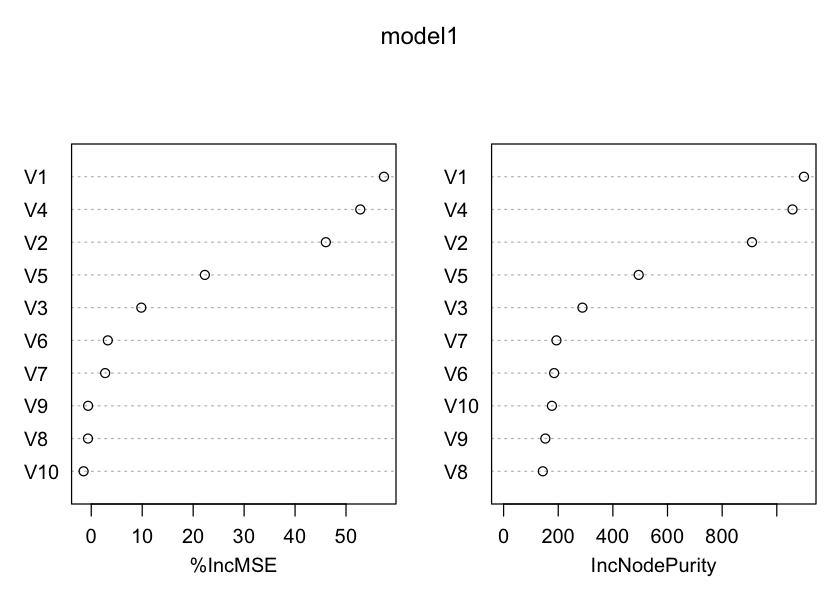

In [64]:
options(repr.plot.width=7, repr.plot.height=5)
varImpPlot(model1)

As we can see, the uninformative variables (V6 - V10) were not used as significant as the other variables

### (b) Now add an additional predictor that is highly correlated with one of the informative predictors. For example:

In [90]:
simulated$duplicate1 <- simulated$V1 + rnorm(200) * .1
cor(simulated$duplicate1, simulated$V1)

[1] 0.9396216

### Fit another random forest model to these data. Did the importance score for V1 change? What happens when you add another predictor that is also highly correlated with V1?

In [66]:
model2 <- randomForest(y ~ ., data = simulated,
                       importance = TRUE,
                       ntree = 1000)

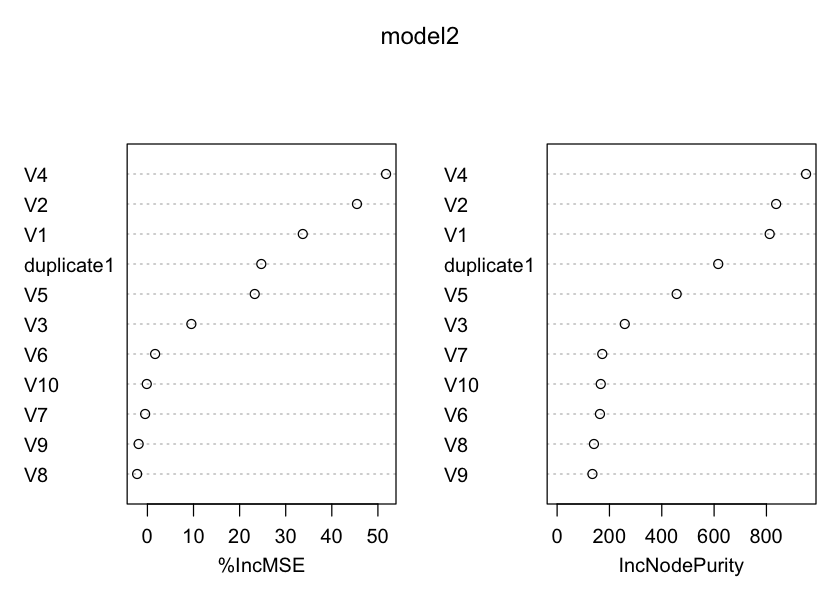

In [92]:
varImpPlot(model2)

In [93]:
rfImp2 <- varImp(model2, scale = FALSE)
rfImp2

,Overall
V1,6.29780744
V2,6.08038134
V3,0.58410718
V4,6.93924427
V5,2.03104094
V6,0.07947642
V7,-0.02566414
V8,-0.11007435
V9,-0.08839463
V10,-0.00715093


In [94]:
cbind(rbind(rfImp1, "duplicate1" = 0), rfImp2)

,Overall,Overall
V1,8.83890885,6.29780744
V2,6.49023056,6.08038134
V3,0.67583163,0.58410718
V4,7.58822553,6.93924427
V5,2.27426009,2.03104094
V6,0.17436781,0.07947642
V7,0.15136583,-0.02566414
V8,-0.03078937,-0.11007435
V9,-0.02989832,-0.08839463
V10,-0.08529218,-0.00715093


This decreases importance of the predictor V1.

### (c) Use the cforest function in the party package to ﬁt a random forest model using conditional inference trees. The party package function varimp can calculate predictor importance. The conditional argument of that function toggles between the traditional importance measure and the modiﬁed version described in Strobl et al. (2007). Do these importances show the same pattern as the traditional random forest model?

In [111]:
library(party)
set.seed(47)
simulated_ori <- simulated[, !colnames(simulated) %in% c('duplicate1')]
model3 <- cforest(y ~ ., data=simulated_ori,
                 control=cforest_unbiased(ntree = 1000))
model4 <- cforest(y ~ ., data=simulated_ori,
                 control=cforest_classical(ntree = 1000))

In [119]:
d <- data.frame(varImp(model1, scale = FALSE), varImp(model3), varImp(model4))
colnames(d) <- c("random forest", "cforest_unbiased", "cforest_classical")

In [120]:
d

,random forest,cforest_unbiased,cforest_classical
V1,8.83890885,8.911598714,9.01359459
V2,6.49023056,6.538804719,6.75334205
V3,0.67583163,0.024218012,0.06950049
V4,7.58822553,8.503106066,8.66712634
V5,2.27426009,2.013761765,2.19851154
V6,0.17436781,-0.009487365,-0.02531449
V7,0.15136583,0.015529441,0.06829946
V8,-0.03078937,-0.028072404,-0.01584600
V9,-0.02989832,-0.019521724,-0.06001097
V10,-0.08529218,-0.037879377,0.04679970


Yes it does show similar pattern as the random forest in a way that it shows same order for the significant variables. Digits are different